# Pre-work steps

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [4]:
# Display Options
pd.set_option('display.min_rows', 25)
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [5]:
#color palette
color_palette = ['#B4D8B2', '#4572C5']  # Hex codes

Stand-alone tables

In [6]:
# orders_clean_df.csv
orders_clean_df = "https://drive.google.com/file/d/1ZEuWF3-pKYC-i6fP8unAAG_JMqU2KEyc/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+orders_clean_df.split("/")[-2]
orders_clean_df = pd.read_csv(path)

# orderlines_clean_df.csv
orderlines_clean_df = "https://drive.google.com/file/d/1IbRAfLGhL7Yf_b8CVkknwhnzsdTBeCIt/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+orderlines_clean_df.split("/")[-2]
orderlines_clean_df = pd.read_csv(path)

# products_categorized_df.csv
products_categorized_df = "https://drive.google.com/file/d/12O5WsGIjbpwmKb-yU7ovn_UUNntvFOpa/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+products_categorized_df.split("/")[-2]
products_categorized_df = pd.read_csv(path)

# brands_clean_df.csv
brands_clean_df = "https://drive.google.com/file/d/1V33HMpSmSLjWSzmGv4is26QKIC_cqNpk/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+brands_clean_df.split("/")[-2]
brands_clean_df = pd.read_csv(path)

In [7]:
#copies of stand-alone DataFrames for manipulation
o_cl=orders_clean_df.copy()
ol_cl=orderlines_clean_df.copy()
p_cl=products_categorized_df.copy()
b_cl=brands_clean_df.copy()

In [8]:
o_cl["created_date"]=pd.to_datetime(o_cl["created_date"])
ol_cl["date"]=pd.to_datetime(ol_cl["date"])

Merged tables

In [9]:
# orderlines_products_df.csv
orderlines_products_df = "https://drive.google.com/file/d/18GF4nNwkb7NIJUfWRRZfX_Ffd0uSXfAa/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+orderlines_products_df.split("/")[-2]
orderlines_products_df = pd.read_csv(path)

# products_brands_df.csv
products_brands_df = "https://drive.google.com/file/d/1zfw-1qZjcMiiI6Pwnhfx5yidCvCA-5Wt/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+products_brands_df.split("/")[-2]
products_brands_df = pd.read_csv(path)

In [10]:
#copies of merged DataFrames for manipulation
ol_p=orderlines_products_df.copy()
p_b=products_brands_df.copy()

In [11]:
#changing the column "date" dtype to datetime to enable calculations
ol_p["date"]=pd.to_datetime(ol_p["date"])

In [12]:
#checking if dtype successfully changed
ol_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53231 entries, 0 to 53230
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                53231 non-null  int64         
 1   id_order          53231 non-null  int64         
 2   product_id        53231 non-null  int64         
 3   product_quantity  53231 non-null  int64         
 4   sku               53231 non-null  object        
 5   unit_price        53231 non-null  float64       
 6   date              53231 non-null  datetime64[ns]
 7   unit_price_total  53231 non-null  float64       
 8   name              53231 non-null  object        
 9   desc              53231 non-null  object        
 10  price             53231 non-null  float64       
 11  in_stock          53231 non-null  int64         
 12  type              53220 non-null  object        
 13  category          53220 non-null  object        
 14  sub-category      5322

In [13]:
#merging the "orderlines_products" already-merged table with the brands table (merging on 'sku' then replacing short/long for 'brand')

ol_p["brand"]= ''
ol_p["brand"] = ol_p["sku"].str[:3]

ol_p_b = ol_p.merge(b_cl, how='left', left_on='brand', right_on='short')
ol_p_b.drop(['brand', 'short'], axis=1, inplace=True)
ol_p_b.rename(columns={'long': 'brand'}, inplace=True)

In [14]:
#adding orders to the "ol_p_b" merged table to have all tables as one
all_tables = ol_p_b.merge(o_cl, how='left', left_on='id_order', right_on='order_id')

In [15]:
#creating a new column for "delivery" (difference between total_paid and unit_price_total, which should be explained by delivery costs)
all_tables.loc[:,'delivery'] = all_tables['total_paid'] - all_tables['unit_price_total']

# Analyses

## New and calculated columns

In [16]:
#converting datetime to date (removing times) and adding additional columns ("quarter", "year" and "week")
all_tables.loc[:,"created_date"]=all_tables["created_date"].dt.date
all_tables.loc[:,"quarter"]=all_tables["created_date"].dt.quarter
all_tables.loc[:,"year"]=all_tables["created_date"].dt.year
all_tables.loc[:,"week"]=all_tables["created_date"].dt.isocalendar().week


#creating a new column that looks at whether products received a discount (relative to base price), were charged more, or stayed the same
#positive "%_change" = % discount to customer; negative "%_change" = % gains for Eniac
all_tables['%_change'] = (
    (all_tables['discount']) / all_tables['price'].replace(0, float('nan'))
    ) * 100


In [17]:
#creating a calculated "price_total" column, using column "price" instead of "unit_price" (similar to the calculated "unit_price_total" column)
all_tables['price_total'] = all_tables['price'] * all_tables['product_quantity']

#looking at the difference between price_total and unit_price_total
#(positive number=discount/loss to company, negative number=higher price/win for company)
all_tables['dif_base_price'] = all_tables['price_total'] - all_tables['unit_price_total']

In [18]:
losses = all_tables[all_tables['dif_base_price'] > 0] # loss to company (earnings below "base" price)
gains = all_tables[all_tables['dif_base_price'] < 0] # gains to company (earnings above "base" price)

Eniac_losses = losses['dif_base_price'].sum()
Eniac_gains = gains['dif_base_price'].sum()

## Reorganized and selected columns

In [19]:
#selecting and reorganizing columns for easier read and work
all_tables=all_tables[['order_id','created_date','sku', 'in_stock', 'name', 'desc','brand','category','sub-category','condition','price','unit_price','discount','%_change','delivery','unit_price_total','total_paid','price_total','dif_base_price','product_quantity','quarter','year','week']]

In [20]:
#checking on changes
all_tables.head(2)

,order_id,created_date,sku,in_stock,name,desc,brand,category,sub-category,condition,...,%_change,delivery,unit_price_total,total_paid,price_total,dif_base_price,product_quantity,quarter,year,week
0,299545,2017-01-01,OWC0100,1,OWC In-line Digital Temperature Sensor Kit HDD iMac 2011,Kit temperature sensor for HDD iMac 21 inch and 27 inch 2011.,OWC,Services,Repair,New,...,22.13,3.99,47.49,51.48,60.99,13.50,1,1,2017,52
1,299546,2017-01-01,IOT0014,0,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s / 5c / 4S,iOttie,Accessories,Stands & Docks,New,...,17.25,0.00,18.99,18.99,22.95,3.96,1,1,2017,52


## What is the time period that the dataset covers?

In [21]:
#the complete dataset date ranges= 2017-01-01 to 2018-03-14
all_tables["created_date"].min(), all_tables["created_date"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-03-14 00:00:00'))

In [22]:
#amount of time represented by the dataset? #437 days
all_tables["created_date"].max()- all_tables["created_date"].min()

Timedelta('437 days 00:00:00')

## How many products are there?

In [23]:
#there are 9992 unique products in the dataset
p_cl['sku'].nunique()

9992

In [24]:
#4537 unique products in 2017
#2559 new products came in for 2018

#Grouping by 'year' and calculating the number of unique 'sku'
unique_sku_by_year = all_tables.groupby('year')['sku'].nunique().reset_index()

#Rename 'sku' column for clarity
unique_sku_by_year.columns = ['year', 'unique_sku_count']
unique_sku_by_year

,year,unique_sku_count
0,2017,4537
1,2018,2559


## What is the total revenue?

In [25]:
#revenue being calculated as gross income
#for our dataset ='total_paid', as it includes the shipment/delivery costs, and the completed orders('state'=="Completed")

In [26]:
#total revenue for the time covered in the dataset= 11,803,686.56 Euros
all_tables["total_paid"].sum().round(2)

11803686.56

In [27]:
#total revenue for only 2017 = 9,417,271.82 Euros, and for only 2018 (3+ months only)= 2,386,414.74 Euros
all_tables.groupby("year")["total_paid"].sum()

,total_paid
year,
2017,9417271.82
2018,2386414.74


## What are the most sold products?

In [28]:
#10 most sold products
all_tables.groupby(['sku','name','category','sub-category'])['product_quantity'].sum().nlargest(10).reset_index()

,sku,name,category,sub-category,product_quantity
0,APP1190,IPhone AppleCare Protection Plan,Services,Apple Care Protection Plan,955
1,APP0698,Apple Lightning Cable Connector to USB 1m White (OEM),Accessories,Adapter,820
2,APP1922,AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch,Components,Headphones & Headsets,537
3,APP0927,EarPods Apple Headphones with Remote and Mic (OEM),Components,Headphones & Headsets,489
4,WDT0183,"Red 4TB WD 35 ""Mac PC hard drive and NAS",Components,Harddrives,476
5,SAM0074,Samsung 850 EVO SSD Disk 500GB,Components,Harddrives,329
6,CRU0051,Crucial MX300 525GB SSD Disk,Components,Harddrives,328
7,APP2446,Apple iPhone 6 32GB Space Gray,Smartphone,iPhone,270
8,NTE0013,"AdaptaDrive NewerTech adapter 2.5 ""to 3.5"" SATA",Services,Repair,252
9,CRU0050,Crucial MX300 275GB SSD Disk,Components,Harddrives,248


## What are the products that generate the most revenue?

In [29]:
#10 most income generating products
all_tables.groupby(['order_id','sku','name','category', 'sub-category','price','discount','unit_price','product_quantity'])['total_paid'].sum().nlargest(10).reset_index()

,order_id,sku,name,category,sub-category,price,discount,unit_price,product_quantity,total_paid
0,434662,SAM0070,512GB Samsung SSD 850 PRO,Components,Harddrives,249.99,35.09,214.90,32,6876.94
1,499191,LGE0044,"LG 27UD88-W Monitor 27 ""UHD 4K USB 3.0 USB-C",Components,Monitor,599.00,29.01,569.99,12,6846.87
2,388292,DLL0035,"Dell U2415 Monitor 24 ""FHD",Components,Monitor,371.99,82.00,289.99,20,5799.80
3,364878,APP0023,Apple Mac Keyboard Keypad Spanish,Desktop,iMac,59.00,3.01,55.99,6,4493.82
4,364878,APP0025,Mighty Mouse Apple Mouse for Mac,Components,Mouses,59.00,2.01,56.99,6,4493.82
5,364878,APP0909,Apple Mac mini Core i5 14GHz | 8GB RAM | 500GB HDD,Laptop,MacBook,675.59,39.60,635.99,6,4493.82
6,403104,LGE0044,"LG 27UD88-W Monitor 27 ""UHD 4K USB 3.0 USB-C",Components,Monitor,599.00,39.01,559.99,8,4479.92
7,355941,APP1985,Apple iPad Wi-Fi + Cellular 128GB Space Gray,Desktop,iMac,662.81,30.81,632.00,7,4424.00
8,435746,WAC0191,Education - Wacom Intuos Comic M Black,Tablet,Graphic tablets,199.99,58.32,141.67,27,3825.13
9,417672,DLL0015,"Dell U2715H Monitor 27 ""LED Slim Marco",Components,Monitor,574.99,132.25,442.74,8,3541.92


## Does revenue grow whenever discounts increase?

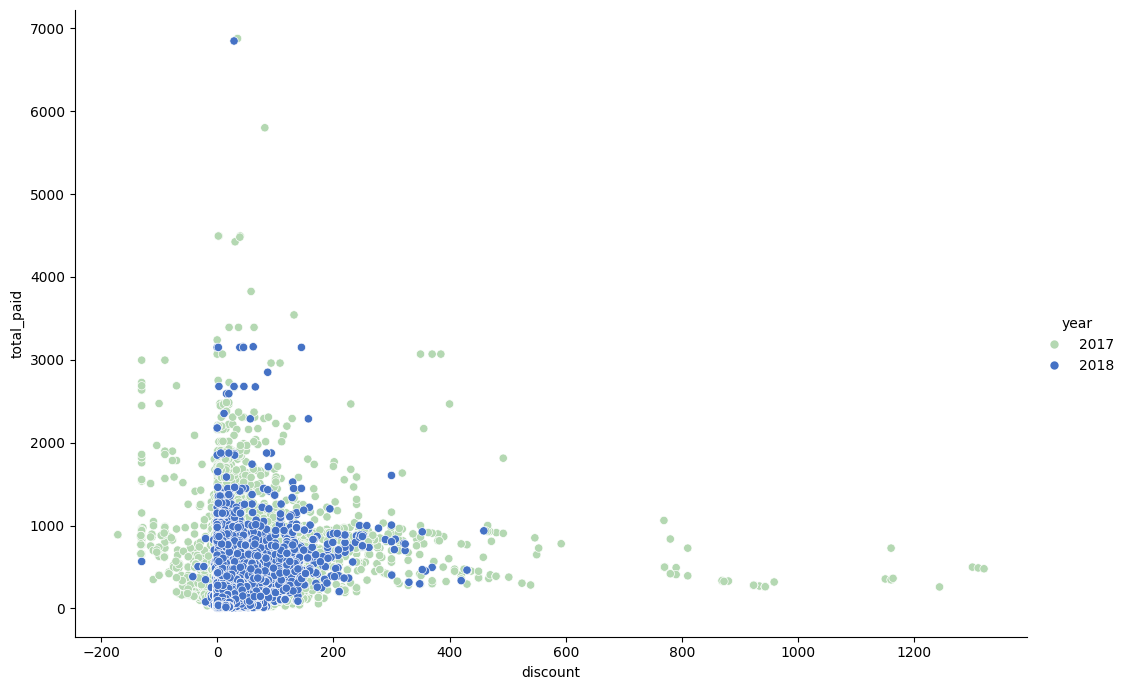

In [30]:
#short answer: after a certain point, "no"
#this did not seem to make a difference by year, although in 2017 Eniac was able to charge more than base price
#in 2017 higher prices ("earnings" compared to base price) make up for some of the discounts?!
sns.relplot(data=all_tables,
            x="discount",
            y="total_paid",
            hue="year",
            height=7,
            aspect=1.5,
            palette=color_palette)


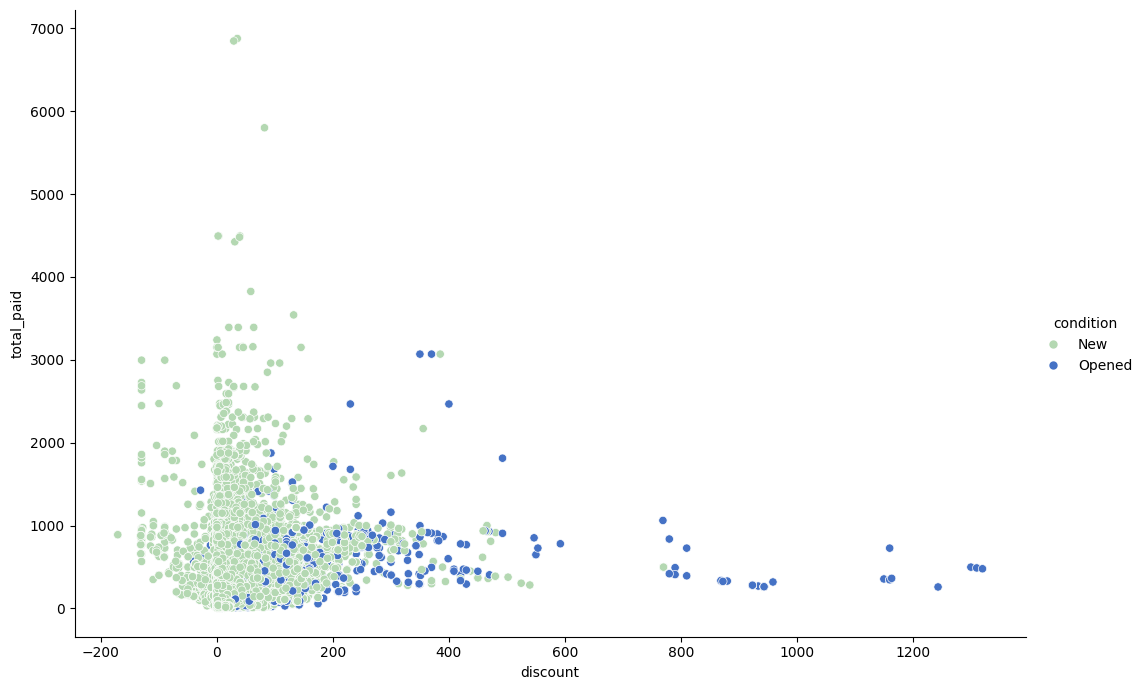

In [31]:
#opened packages receive the highest discounts (looking at complete dataset, 1+ years)
sns.relplot(data=all_tables,
            x="discount",
            y="total_paid",
            hue="condition",
            height=7,
            aspect=1.5,
            palette=color_palette)

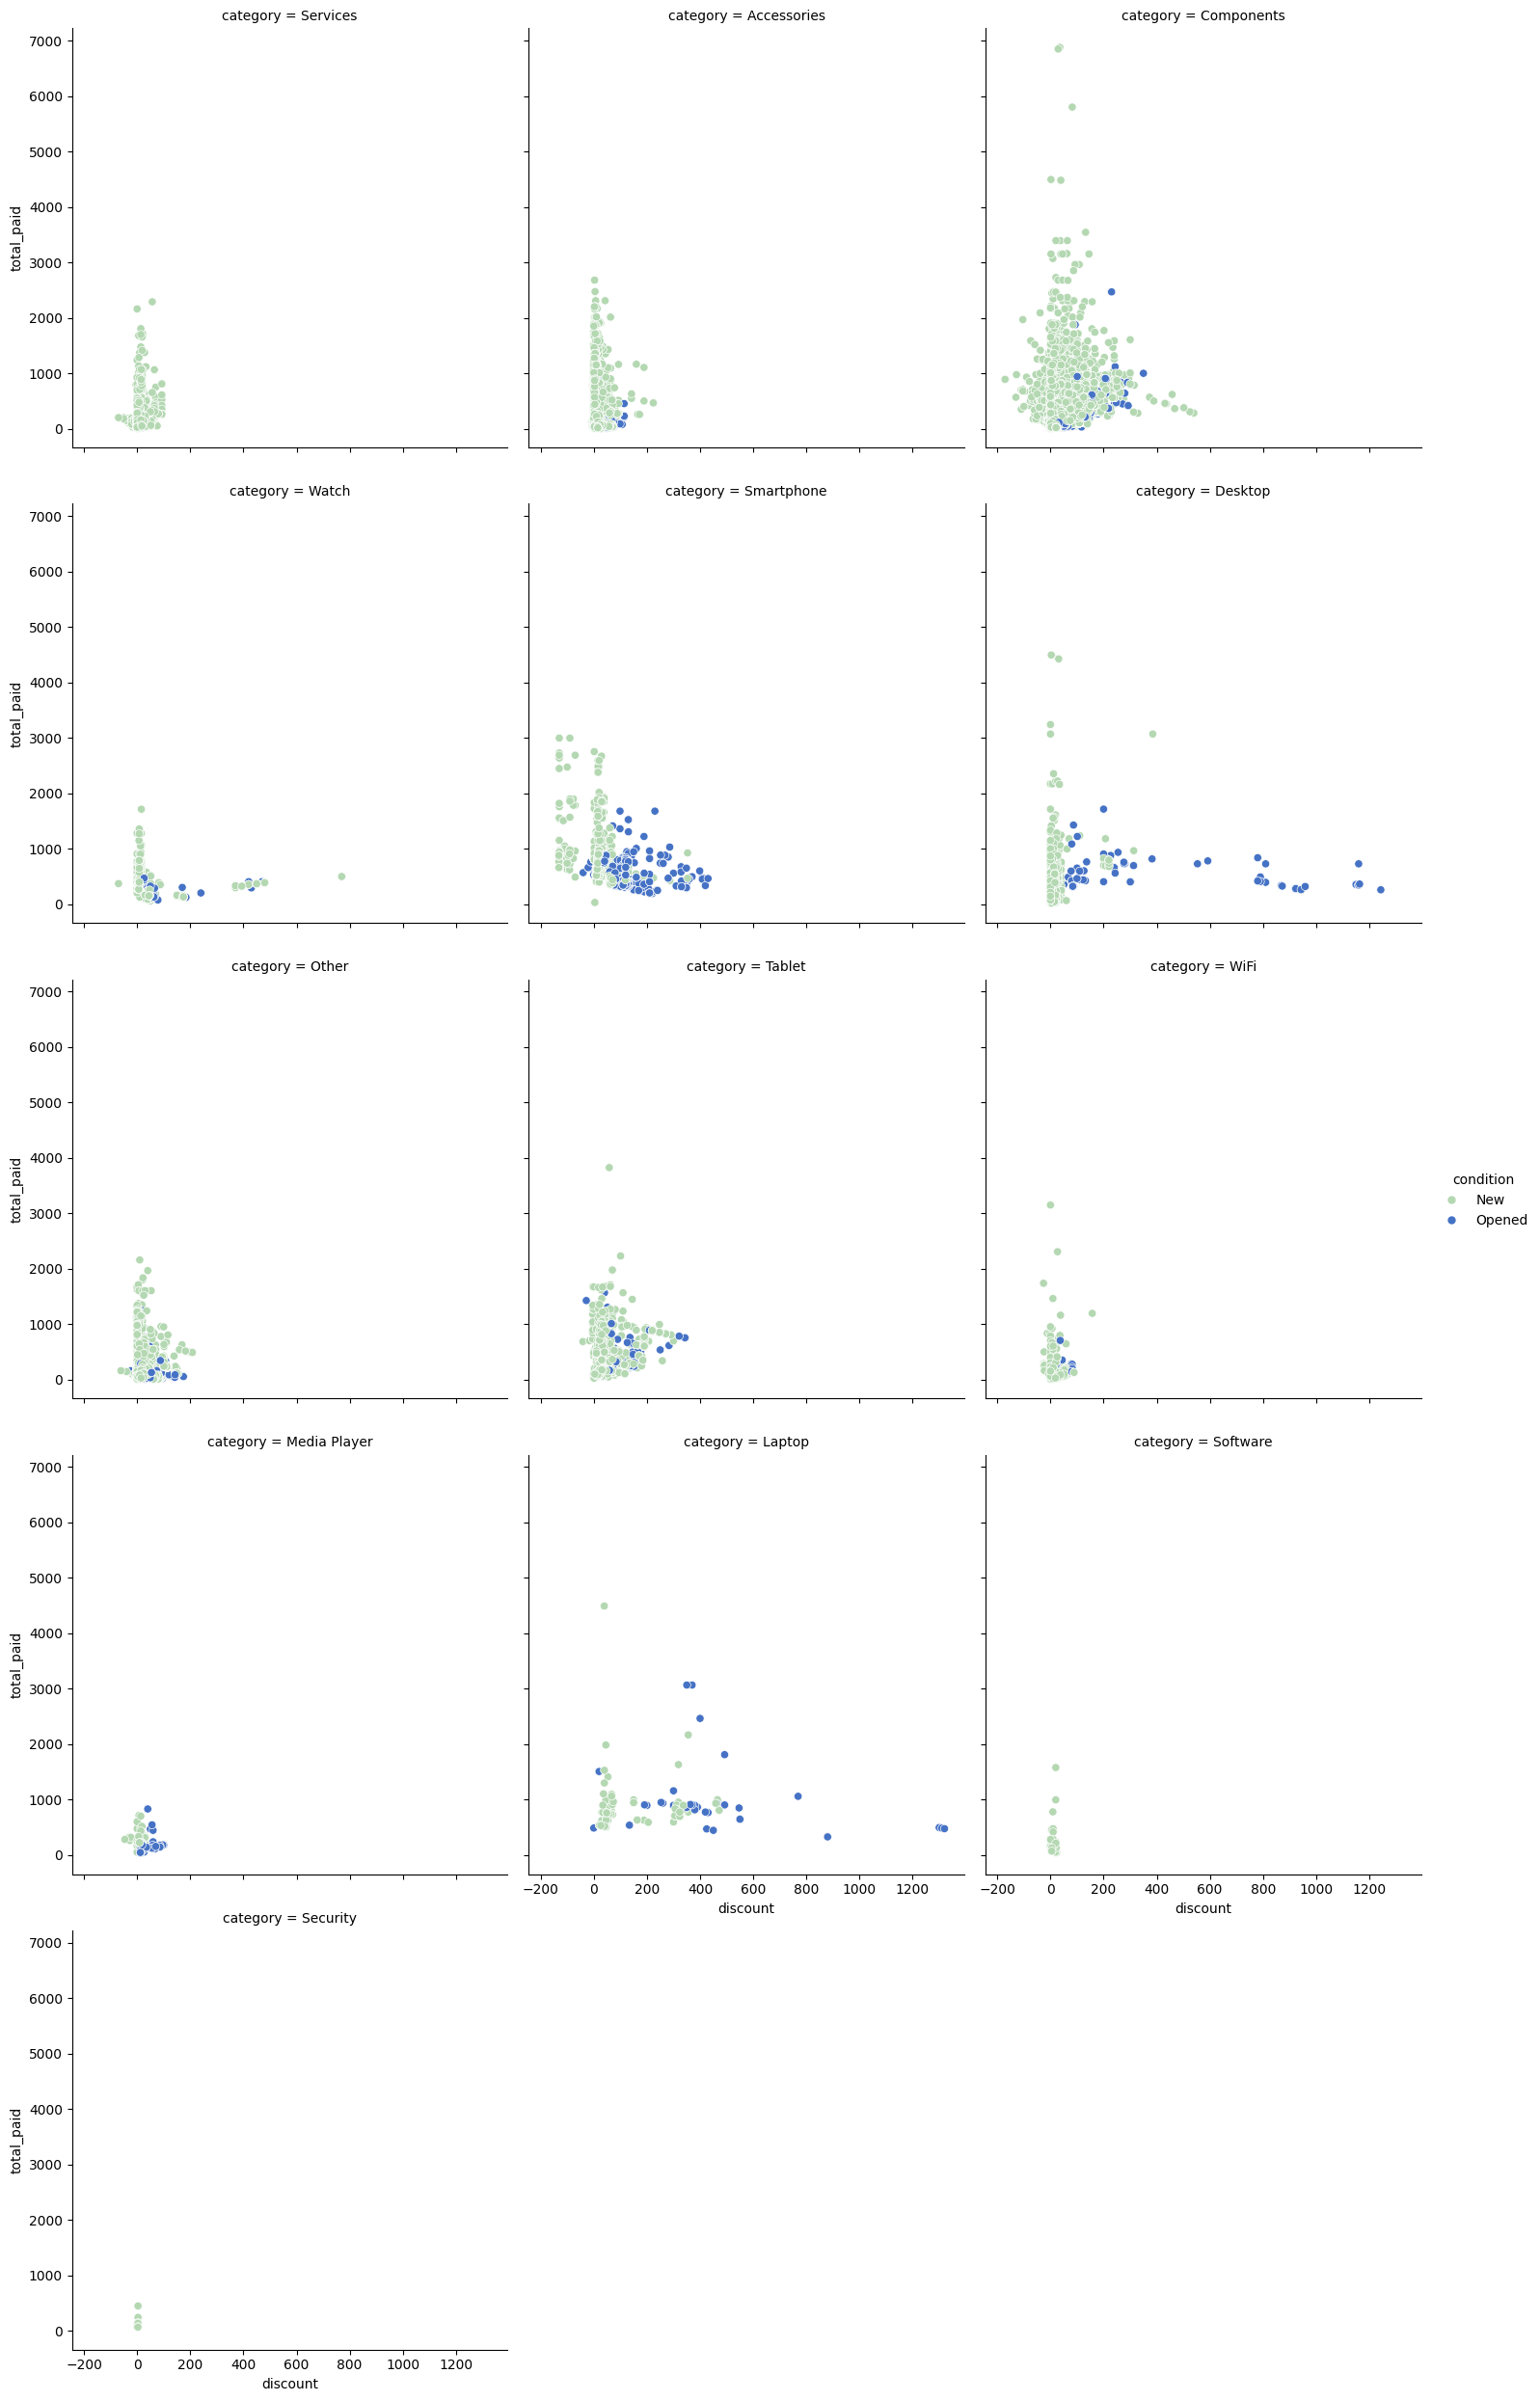

In [32]:
#specific categories sell more when discounted AND opened but does not bring a higher revenue (except for laptops)
#looking at complete dataset, 1 years and 3.5 months
sns.relplot(data=all_tables,
            x="discount",
            y="total_paid",
            hue="condition",
            col="category",
            palette=color_palette,
            col_wrap=3)

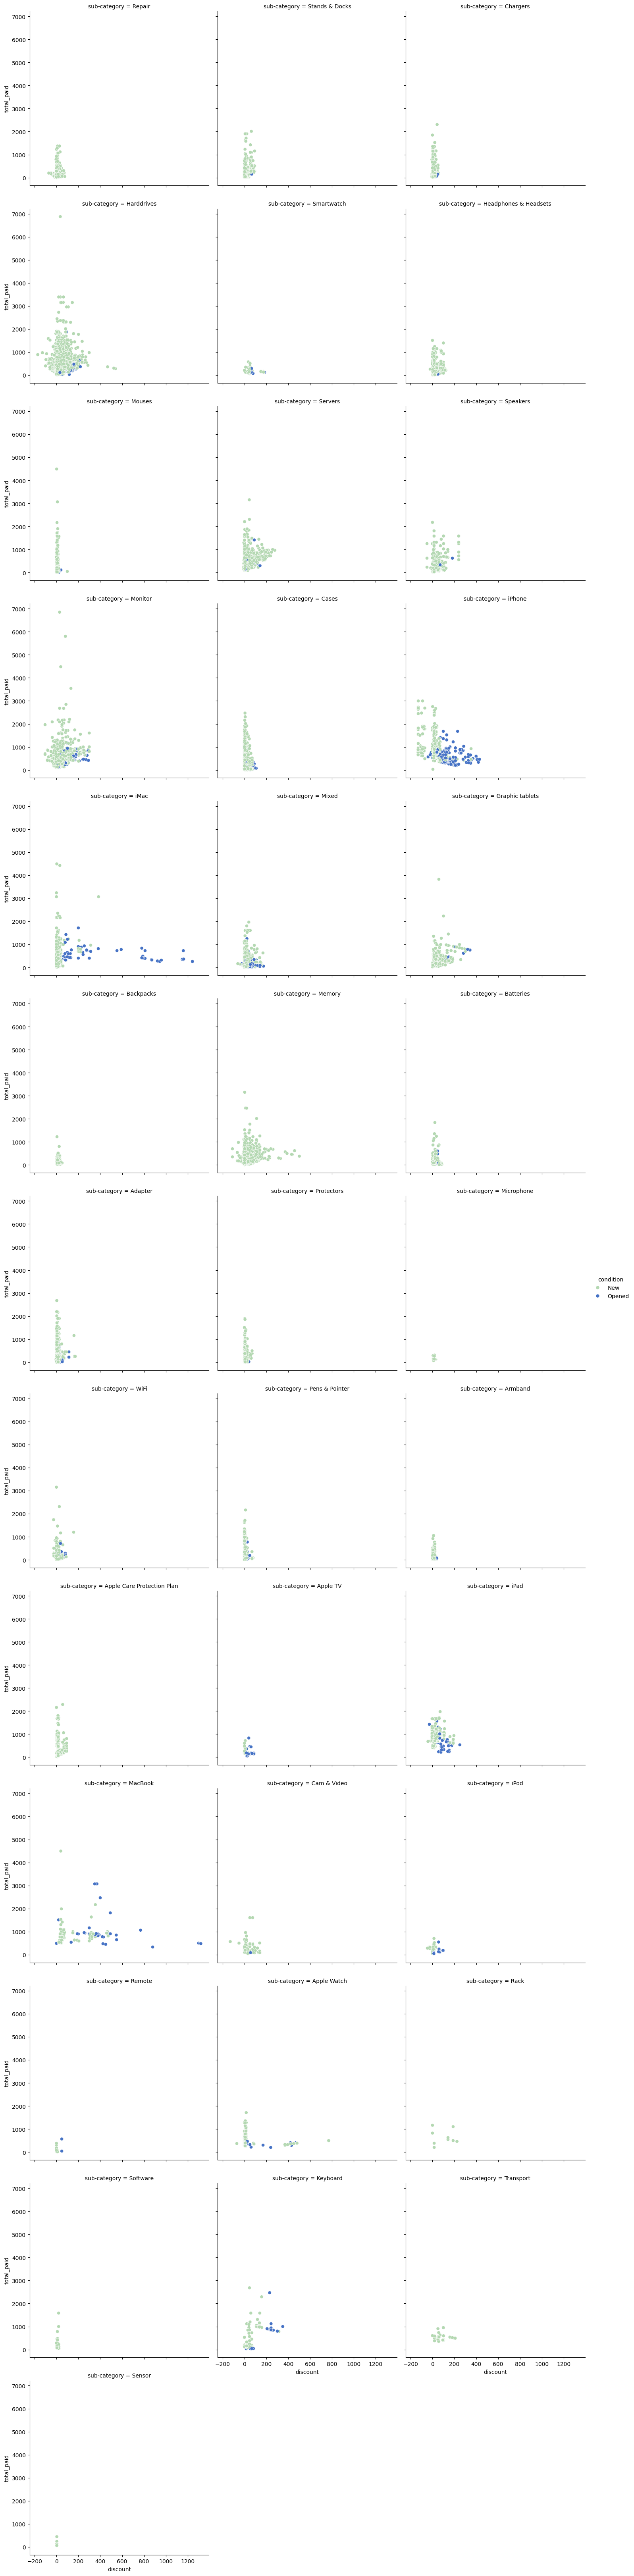

In [33]:
#opened iMacs and iPhones that are opened receive the greatest discounts from all sub-categories
sns.relplot(data=all_tables,
            x="discount",
            y="total_paid",
            hue="condition",
            col="sub-category",
            palette=color_palette,
            col_wrap=3)

## Development of orders and revenue over time

Eniac's board reported "an increase in orders placed but decrease in total revenue". What does a longer-term trend look like?




### Evolution of total orders over time (quarters) - 2017 vs 2018

In [34]:
grouped_data_orders = all_tables.groupby(['quarter','year']).size().reset_index(name='order_count')

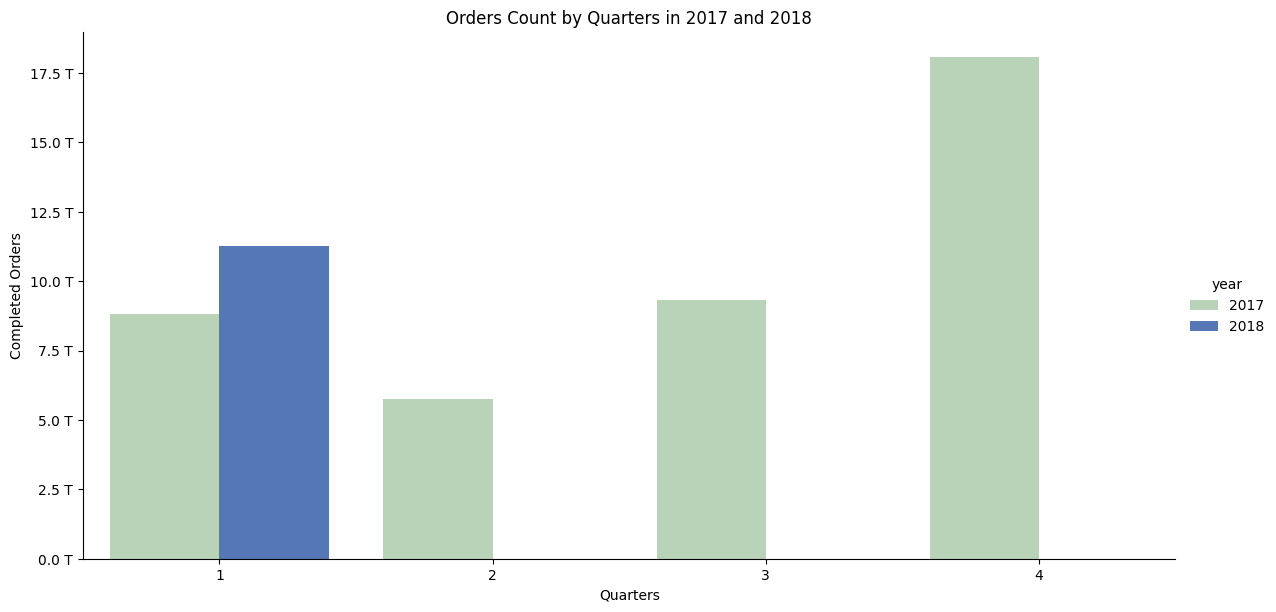

In [35]:
#2018 Q1 sales were lower than 2017 Q4, BUT, they were higher than 2017 Q1
#positive trend in sales increasing

# Defining the y-axis
def yaxis_format(tick, pos):
    return f'{tick / 1000:.1f} T'

catplot = sns.catplot(
    data=grouped_data_orders,
    x="quarter",
    y="order_count",
    hue="year",
    kind="bar",
    palette=color_palette,
    aspect=2,
    height=6
)

# Formatting the y-axis
catplot.ax.yaxis.set_major_formatter(FuncFormatter(yaxis_format))

plt.title("Orders Count by Quarters in 2017 and 2018")
plt.ylabel("Completed Orders")
plt.xlabel("Quarters")


plt.show()


### Evolution of revenue over time (quarters) - 2017 vs 2018

In [36]:
grouped_data_revenue= all_tables.groupby(['quarter', 'year'])['total_paid'].sum().reset_index(name='total_revenue')

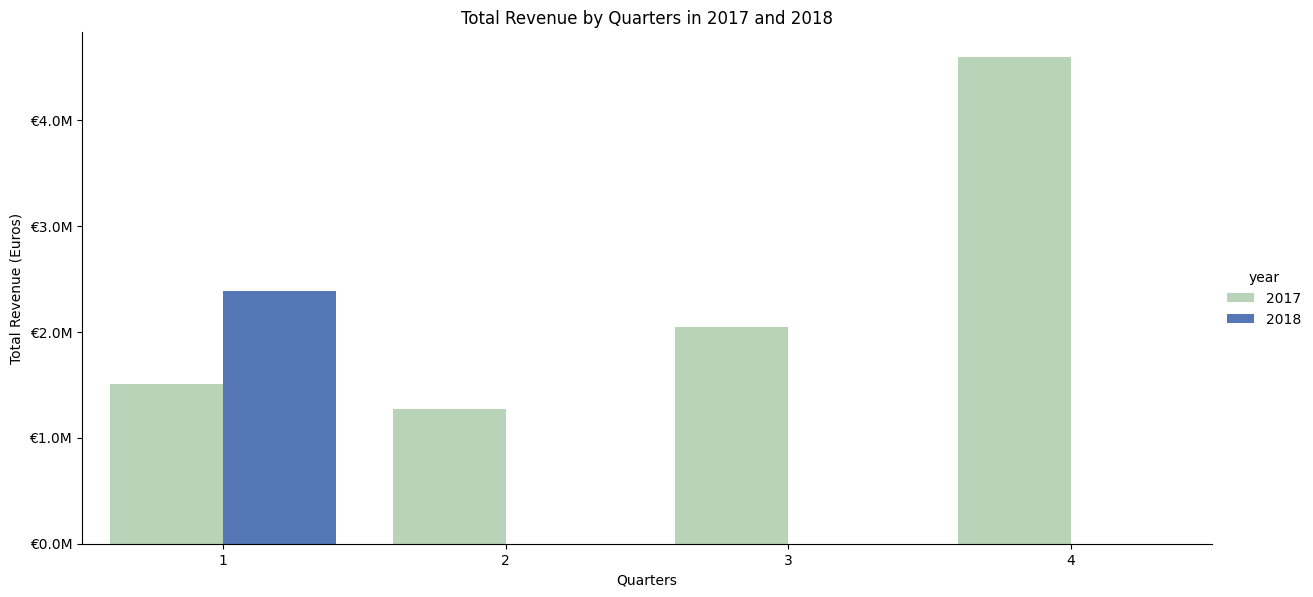

In [37]:
#2018 Q1 revenue was lower than in 2017 Q4, BUT, revenue was higher than in 2017 Q1
#positive trend in revenue development

sns.catplot(
    data=grouped_data_revenue,
    x="quarter",
    y="total_revenue",
    hue="year",
    kind="bar",
    palette=color_palette,
    aspect=2,
    height=6
)

# Customizing the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'€{x/1e6:.1f}M'))


plt.title("Total Revenue by Quarters in 2017 and 2018")
plt.ylabel("Total Revenue (Euros)")
plt.xlabel("Quarters")
plt.show()


### Seasons and sales

Are there seasonal patterns in the evolution of orders completed? (any periods of highest orders completed/peaks, vs lowest orders completed/valleys?)

In [38]:
grouped_data_dates_orders = all_tables.groupby(['week','year']).size().reset_index(name='order_count')

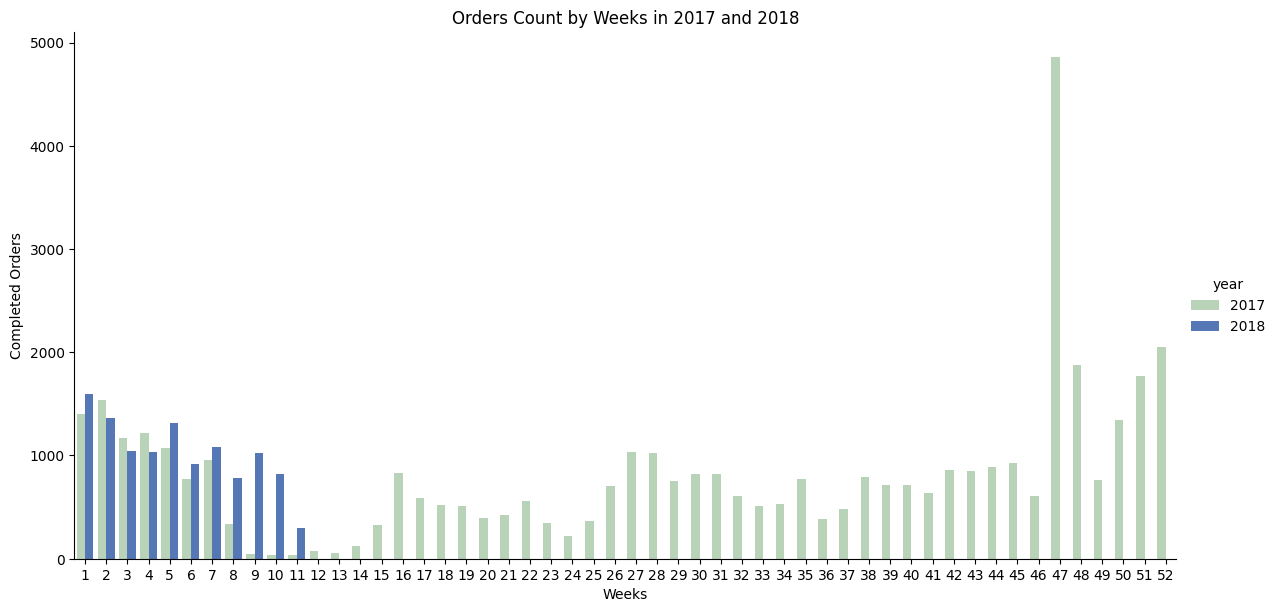

In [39]:
sns.catplot(data=grouped_data_dates_orders,
            x="week",
            y="order_count",
            hue="year",
            kind="bar",
            palette=color_palette,
            height=6,
            aspect=2)

plt.title("Orders Count by Weeks in 2017 and 2018")
plt.ylabel("Completed Orders")
plt.xlabel("Weeks")
plt.show()

### Seasons and revenue

Are there seasonal patterns in the evolution of sales? (any periods of highest sales/peaks, vs lowest sales/valleys?)

In [40]:
grouped_data_dates_revenue = all_tables.groupby(['week','year'])['total_paid'].sum().reset_index(name='total_revenue')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

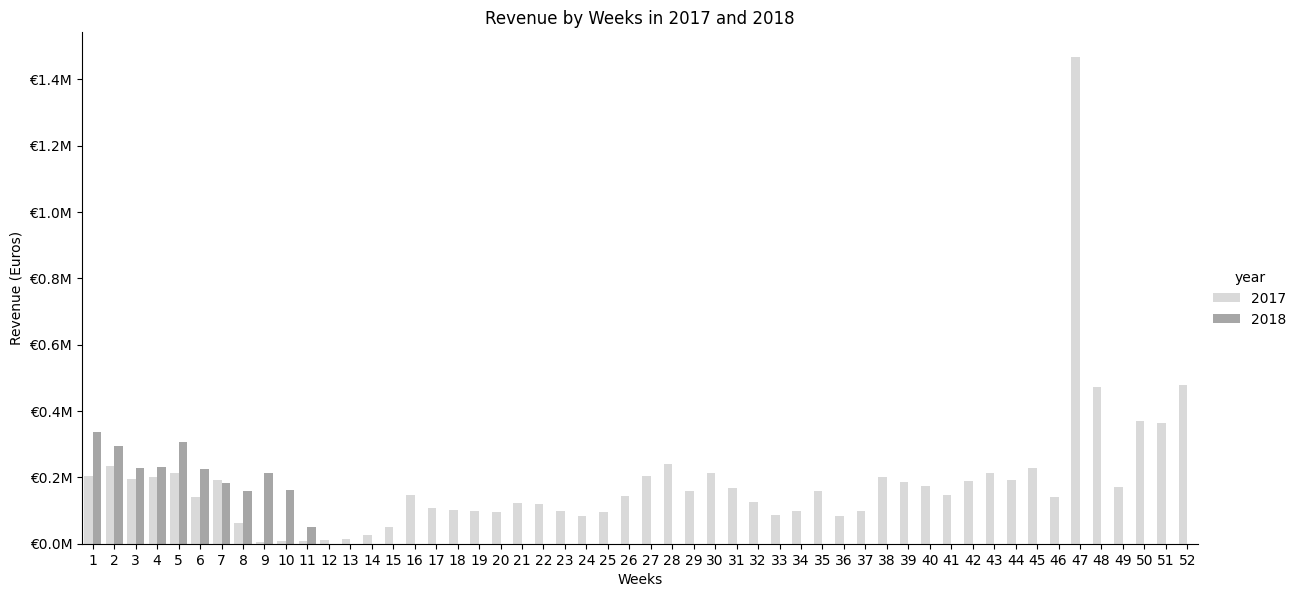

In [41]:
sns.catplot(
    data=grouped_data_dates_revenue,
    x="week",
    y="total_revenue",
    hue="year",
    kind="bar",
    palette=['#D9D9D9','#A6A6A6'],
    height=6,
    aspect=2
)

# Customizing the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'€{x/1e6:.1f}M'))

plt.title("Revenue by Weeks in 2017 and 2018")
plt.ylabel("Revenue (Euros)")
plt.xlabel("Weeks")
plt

## Discounts

### Products being discounted

In [42]:
discounts_2017=all_tables[all_tables['year']==2017]

In [43]:
#Amount of products being discounted (or not) in the year 2017 are as follows:

#1,649 products were not discounted
no_discounts=discounts_2017['discount']==0
no_discounts.sum()

1649

In [44]:
#1,393 products were being charged more than base price
above_base_price=discounts_2017['discount']<0
above_base_price.sum()

1393

In [45]:
#38,923 products are discounted
discounted=discounts_2017['discount']>0
discounted.sum()

38923

### Eniac losses ("discounts") versus gains

In [46]:
#variables and figures based on codes under section above "New and calculated columns"
#"Eniac_losses"= amount total below base price (when product was sold for less than base price, =total of discounts)
#"Eniac_gains"= amount total above base price (when product was sold for more than base price, =total of gains)

# Filtering for rows where the year is 2017
losses_2017 = losses[losses['year'] == 2017]
gains_2017 = gains[gains['year'] == 2017]

# Calculating the sum of 'dif_base_price' for the filtered data
Eniac_losses_2017 = losses_2017['dif_base_price'].sum()
Eniac_gains_2017 = gains_2017['dif_base_price'].sum()

Eniac_losses_2017, Eniac_gains_2017
#in Euros: 1,228,888.29 - 28,511.98

(1228888.29, -28511.98)

In [47]:
#2017 difference = 1,200,376.31 ("losses" in Euros to Eniac in 2017)
1228888.29 - 28511.98

1200376.31

In [48]:
#checking filtering
all_tables.head(1)

,order_id,created_date,sku,in_stock,name,desc,brand,category,sub-category,condition,...,%_change,delivery,unit_price_total,total_paid,price_total,dif_base_price,product_quantity,quarter,year,week
0,299545,2017-01-01,OWC0100,1,OWC In-line Digital Temperature Sensor Kit HDD iMac 2011,Kit temperature sensor for HDD iMac 21 inch and 27 inch 2011.,OWC,Services,Repair,New,...,22.13,3.99,47.49,51.48,60.99,13.50,1,1,2017,52


### Evolution of losses (discounts) and gains (sales above base price) over time

Looking at the evolution over time (year 2017 in weeks) of Eniac's revenue comparing how much the products **could have sold** for if sold at base price ("price_total") versus how much they **actually sold** for ("unit_price_total").  Products sold below base price are seen as a "loss" to the company, whereas products sold above base price are seen as gains.

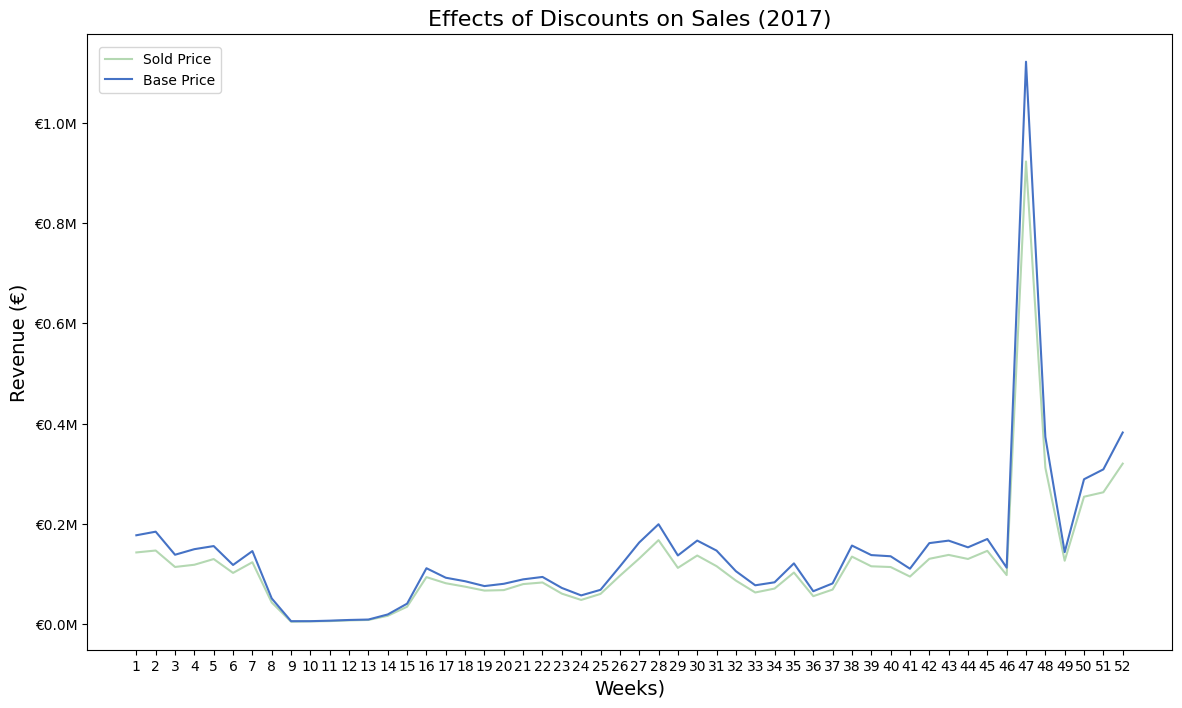

In [51]:
#Plotting shows peaks in sales when more discounts were offered!! Discounts are a good thing for Eniac!!!!!

# Custom formatting of the y-axis to show amounts by the thousands (1,000 = 1K)
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}k'

all_tables_aggregated = all_tables.groupby(['year', 'week'])[['unit_price_total', 'price_total']].sum().reset_index()

# Filtering for the year 2017
all_tables_2017 = all_tables_aggregated[all_tables_aggregated['year'] == 2017]

all_tables_melted_2017 = all_tables_2017.melt(
    id_vars='week',
    value_vars=['unit_price_total', 'price_total'],
    var_name='Category',
    value_name='Value'
)

plt.figure(figsize=(14, 8))

custom_labels = {'unit_price_total': 'Sold Price', 'price_total': 'Base Price'}
all_tables_melted_2017['Category'] = all_tables_melted_2017['Category'].replace(custom_labels)

sns.lineplot(
    data=all_tables_melted_2017,
    x='week',
    y='Value',
    hue='Category',
    palette=color_palette)

# Setting all weeks as x-axis ticks
weeks = sorted(all_tables_melted_2017['week'].unique())
plt.xticks(weeks, labels=[f'{week}' for week in weeks])

# Customizing the y-axis formatting
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'€{x/1e6:.1f}M'))

plt.title('Effects of Discounts on Sales (2017)', fontsize=16)
plt.xlabel('Weeks)', fontsize=14)
plt.ylabel('Revenue (€)', fontsize=14)
plt.legend(title='', bbox_to_anchor=(0.13, .99))

plt.show()


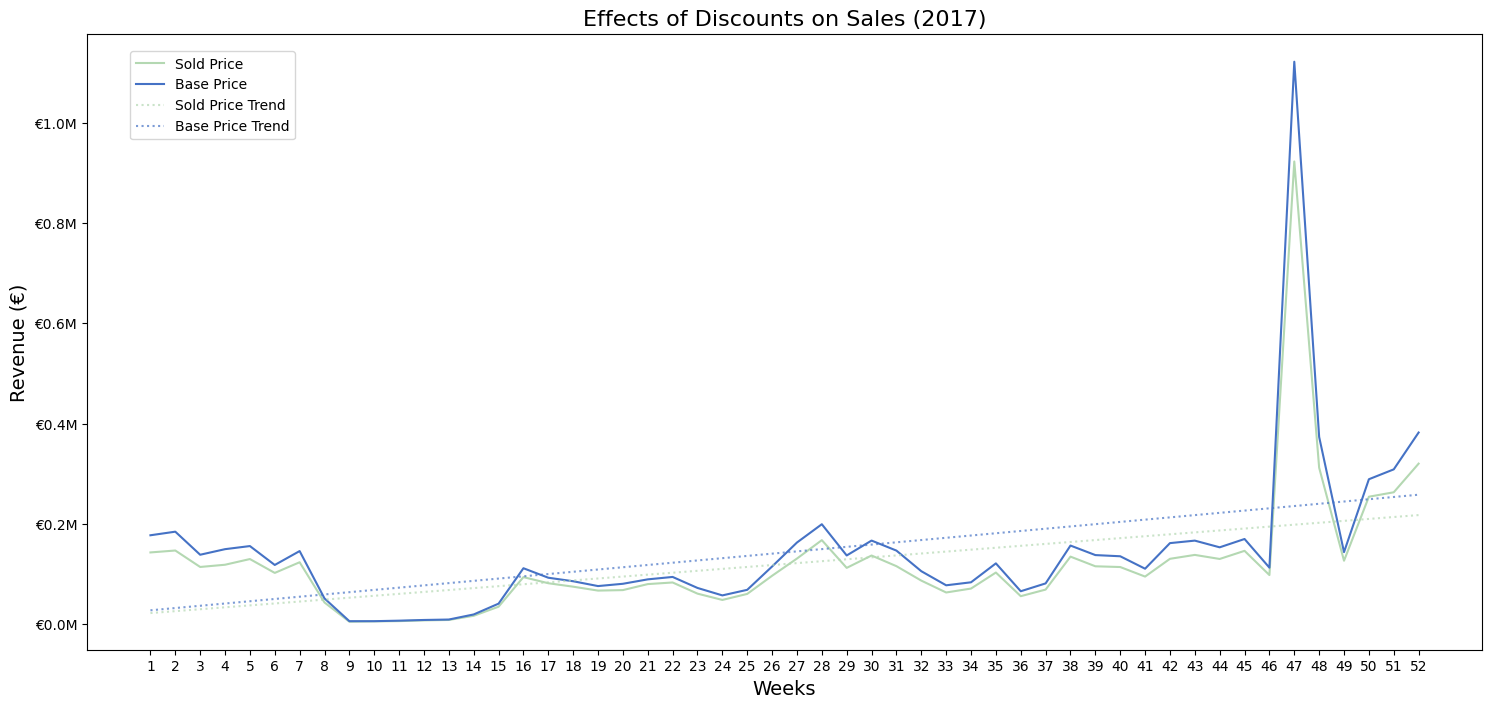

In [52]:
#Adding trend lines makes it even clearer that the greater the discounts, the greater the sales revenues
#again, discounts are a good thing for Eniac!!!!!

# Custom formatting of the y-axis to show amounts by the thousands (1,000 = 1K)
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}k'

custom_labels = {'unit_price_total': 'Sold Price', 'price_total': 'Base Price'}
all_tables_melted_2017['Category'] = all_tables_melted_2017['Category'].replace(custom_labels)

plt.figure(figsize=(18, 8))

palette = {'Sold Price': '#B4D8B2', 'Base Price': '#4572C5'}

sns.lineplot(
    data=all_tables_melted_2017,
    x='week',
    y='Value',
    hue='Category',
    palette=palette,
    marker=None,
)

categories = all_tables_melted_2017['Category'].unique()
for category in categories:
    # Filtering data
    category_data = all_tables_melted_2017[all_tables_melted_2017['Category'] == category]

    # Performing linear regression
    x = category_data['week']
    y = category_data['Value']
    trend = np.polyfit(x, y, deg=1)
    trend_line = np.polyval(trend, x)

    # Plotting the trend line with matching color
    plt.plot(x, trend_line, linestyle=':', color=palette[category], label=f'{category} Trend', alpha=0.7)

# Setting all weeks as x-axis ticks
weeks = sorted(all_tables_melted_2017['week'].unique())
plt.xticks(weeks, labels=[f'{week}' for week in weeks])

# Customizing the y-axis formatting
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'€{x/1e6:.1f}M'))

plt.title('Effects of Discounts on Sales (2017)', fontsize=16)
plt.xlabel('Weeks', fontsize=14)
plt.ylabel('Revenue (€)', fontsize=14)


# Adjusting the legend box
plt.legend(bbox_to_anchor=(0.09, 0.9), loc='center')

plt.show()


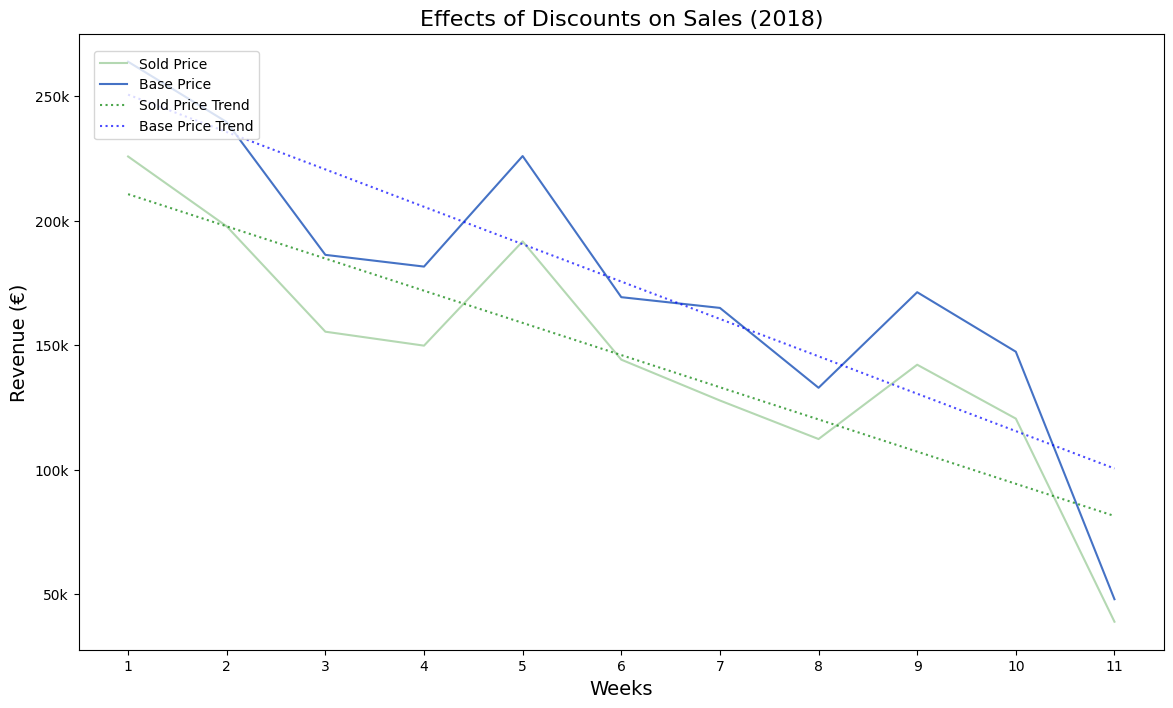

In [53]:
#for 2018 the trend of higher discounts=higher sales continues from 2018, although looking at the first quarter only shows a negative trend line
#this negative trend line is comparative to 2017's when high sales from end of the year started to taper down
#it can be assumed that in 2018 trend lines will be similar to those in 2017
#one can also expect sales to be better in 2018 given the comparison from q1 2018 vs q1 2017 already shows an improvement

# Filter for the year 2018
all_tables_2018 = all_tables_aggregated[all_tables_aggregated['year'] == 2018]

all_tables_melted_2018 = all_tables_2018.melt(
    id_vars='week',
    value_vars=['unit_price_total', 'price_total'],
    var_name='Category',
    value_name='Value'
)

# Custom formatting of the y-axis to show amounts by the thousands (1,000 = 1K)
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}k'

custom_labels = {'unit_price_total': 'Sold Price', 'price_total': 'Base Price'}
all_tables_melted_2018['Category'] = all_tables_melted_2018['Category'].replace(custom_labels)

plt.figure(figsize=(14, 8))

palette = {'Sold Price': 'green', 'Base Price': 'blue'}

sns.lineplot(
    data=all_tables_melted_2018,
    x='week',
    y='Value',
    hue='Category',
    palette=color_palette,
    marker=None
)

categories = all_tables_melted_2018['Category'].unique()
for category in categories:
    # Filtering data
    category_data = all_tables_melted_2018[all_tables_melted_2018['Category'] == category]

    # Performing linear regression
    x = category_data['week']
    y = category_data['Value']
    trend = np.polyfit(x, y, deg=1)
    trend_line = np.polyval(trend, x)

    # Plotting the trend line with matching color
    plt.plot(x, trend_line, linestyle=':', color=palette[category], label=f'{category} Trend', alpha=0.7)

weeks = sorted(all_tables_melted_2018['week'].unique())
plt.xticks(weeks, labels=[f'{week}' for week in weeks])

# Applying custom formatting to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.title('Effects of Discounts on Sales (2018)', fontsize=16)
plt.xlabel('Weeks', fontsize=14)
plt.ylabel('Revenue (€)', fontsize=14)

# Adjusting the legend box
plt.legend(bbox_to_anchor=(0.09, 0.9), loc='center')

plt.show()


### Seasons and discounts

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

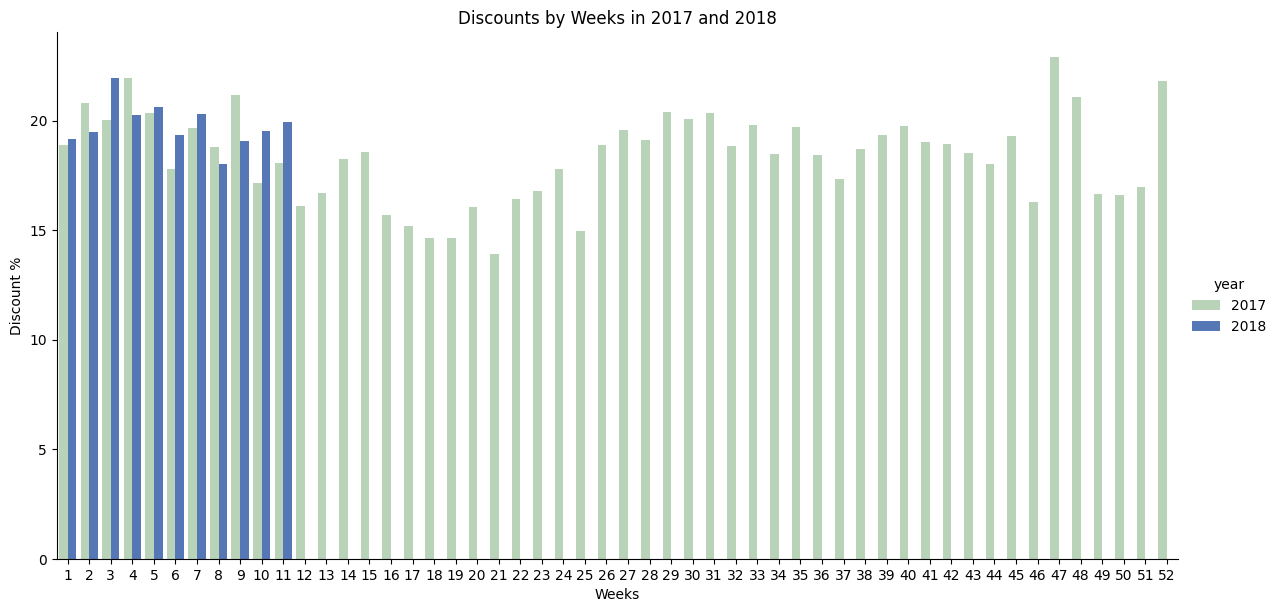

In [54]:
grouped_data_dates_discounts = all_tables.groupby(['week','year','%_change','price','unit_price'])['%_change'].mean().reset_index(name='total_revenue')


sns.catplot(
    data=grouped_data_dates_discounts,
    x="week",
    y="%_change",
    hue="year",
    kind="bar",
    height=6,
    aspect=2,
    palette=color_palette,
    errorbar=None,
)

plt.title("Discounts by Weeks in 2017 and 2018")
plt.ylabel("Discount %")
plt.xlabel("Weeks")
plt

### Relationship between amount of products sold and discount %

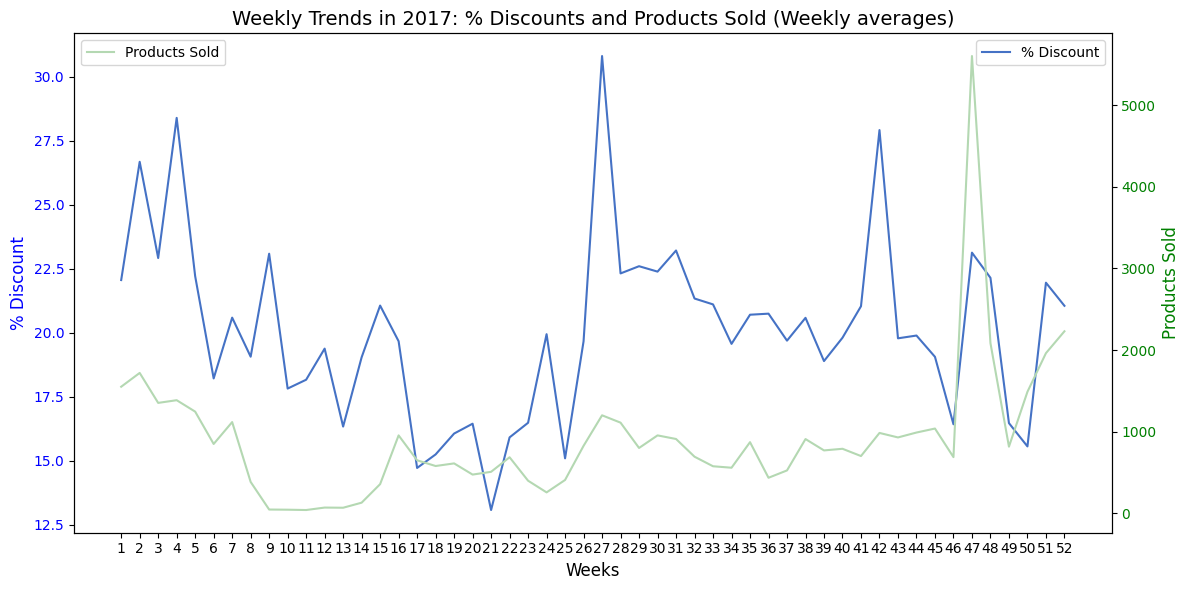

In [55]:
#discounts seem to make a difference in how many products are sold only during special seasons (i.e. black friday and xmas)
#discounts do not seem to make a difference any other time of the year

#when wanting to see plotting by condition "opened" (or "new"):
#filtered_data = all_tables[(all_tables['year'] == 2017) & (all_tables['condition'] == 'Opened')]


# Filter data to include only rows where the year is 2017
filtered_data = all_tables[all_tables['year'] == 2017]

weekly_data = filtered_data.groupby('week').agg(
    avg_percentage_change=('%_change', 'mean'),
    avg_product_quantity=('product_quantity', 'sum')
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_percentage_change',
    ax=ax1,
    color='#4572C5',
    label='% Discount'
)

# Customize the primary y-axis
ax1.set_ylabel('% Discount', fontsize=12,
               color='blue',
               )
ax1.tick_params(axis='y',
                labelcolor='blue',
                )
ax1.set_xlabel('Weeks', fontsize=12)
ax1.set_xticks(weekly_data['week'])
ax1.set_xticklabels(weekly_data['week'])

# Create a secondary y-axis for the average product quantity
ax2 = ax1.twinx()
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_product_quantity',
    ax=ax2,
    color='#B4D8B2',
    label='Products Sold'
)

# Customize the secondary y-axis
ax2.set_ylabel('Products Sold', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green',
                #labelcolor='#B4D8B2'
                )

plt.title('Weekly Trends in 2017: % Discounts and Products Sold (Weekly averages)', fontsize=14)

fig.tight_layout()
plt.show()


### Relationship between order size and discounts

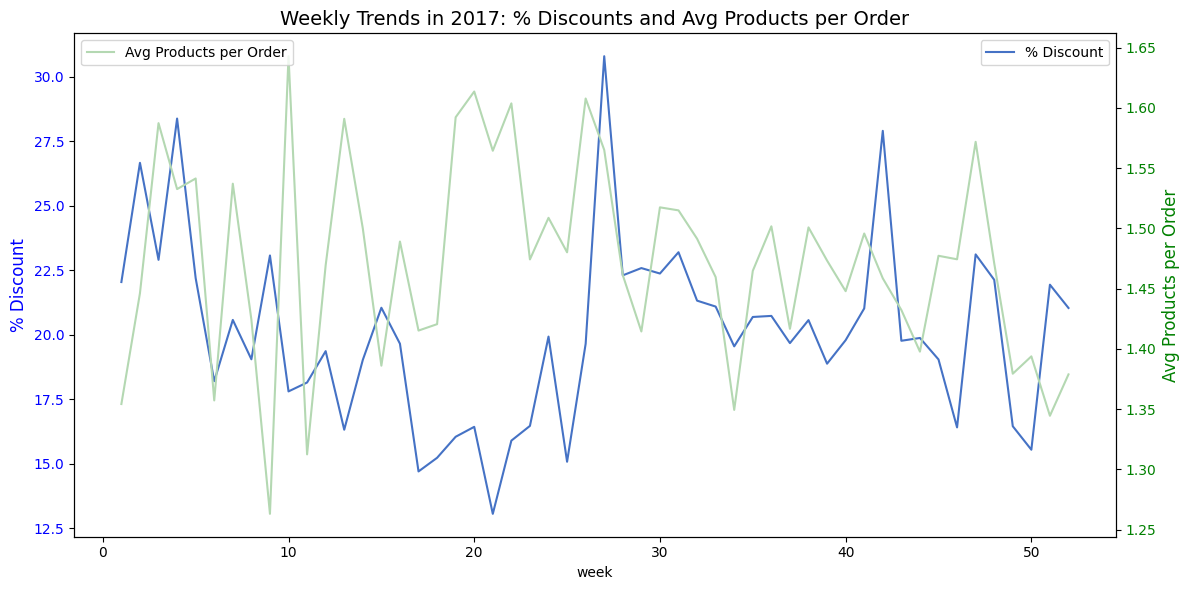

In [59]:
#there does not seem to be a relationship betwween discount % and how many products are ordered/ordered size

avg_products_per_order = (
    filtered_data.groupby(['week', 'order_id'])['product_quantity']
    .sum()
    .groupby('week')
    .mean()
    .reset_index(name='avg_products_per_order')
)

# Merge with weekly_data for combined plotting
weekly_data = filtered_data.groupby('week').agg(
    avg_percentage_change=('%_change', 'mean')
).reset_index()
weekly_data = weekly_data.merge(avg_products_per_order, on='week')

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis plot
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_percentage_change',
    ax=ax1,
    #color='blue',
    color='#4572C5',
    label='% Discount'
)
ax1.set_ylabel('% Discount', fontsize=12, color='blue')
ax1.tick_params(axis='y',
                labelcolor='blue',
                )

# Secondary axis plot
ax2 = ax1.twinx()
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_products_per_order',
    ax=ax2,
    color='#B4D8B2',
    label='Avg Products per Order'
)
ax2.set_ylabel('Avg Products per Order', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # Force whole numbers

plt.title('Weekly Trends in 2017: % Discounts and Avg Products per Order', fontsize=14)
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


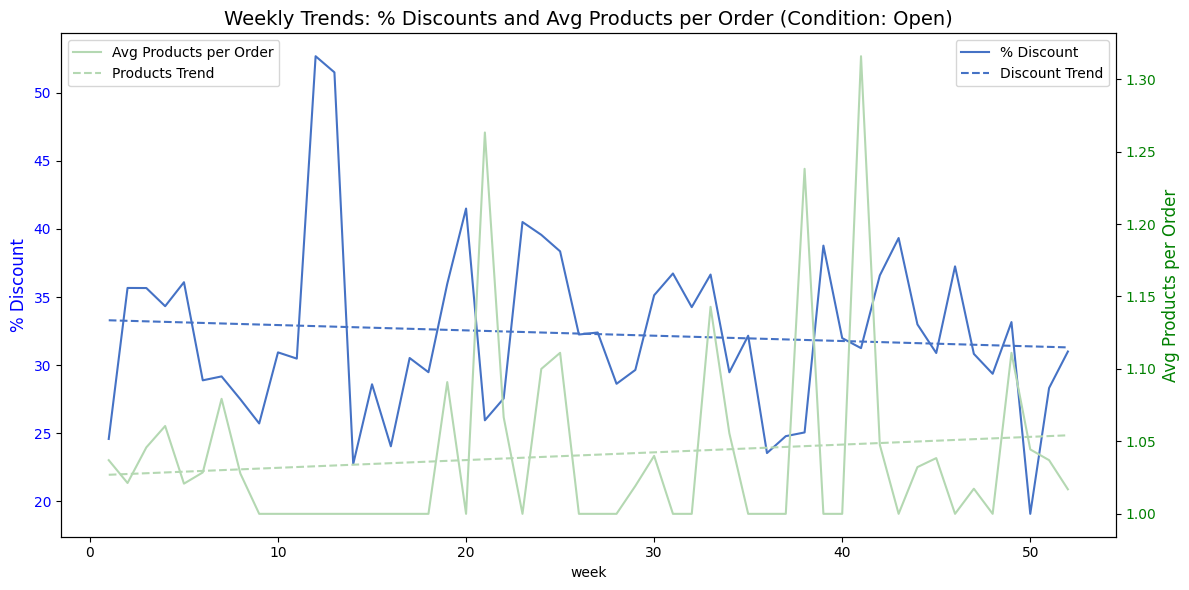

In [62]:
# Step 1: Calculating the average of the '%_change' column
average_discount = all_tables['%_change'].mean()

# Step 2: Grouping by 'category' and calculate the average '%_change'
grouped_avg_discount = all_tables.groupby('category')['%_change'].mean()

# Step 3: Filtering data where 'condition' is 'Opened'
filtered_weekly_data = all_tables[all_tables['condition'] == 'Opened']

# Step 4: Aggregating the data by 'week'
weekly_data = filtered_weekly_data.groupby('week').agg(
    avg_percentage_change=('%_change', 'mean'),
    avg_products_per_order=('product_quantity', 'mean')
).reset_index()

# Step 5: Preparing data for trend lines
X_weeks = weekly_data['week'].values.reshape(-1, 1)

# Step 6: Calculating the trend line for Discount Percentage
discount_model = LinearRegression()
discount_model.fit(X_weeks, weekly_data['avg_percentage_change'])
weekly_data['discount_trend'] = discount_model.predict(X_weeks)

# Step 7: Calculating the trend line for Avg Products per Order
products_model = LinearRegression()
products_model.fit(X_weeks, weekly_data['avg_products_per_order'])
weekly_data['products_trend'] = products_model.predict(X_weeks)

# Step 8: Setting up the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot for % Discount on primary axis
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_percentage_change',
    ax=ax1,
    #color='blue',
    color='#4572C5',
    label='% Discount'
)
sns.lineplot(
    data=weekly_data,
    x='week',
    y='discount_trend',
    ax=ax1,
    #color='blue',
    color='#4572C5',
    linestyle='--',
    label='Discount Trend'
)
ax1.set_ylabel('% Discount', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot for Avg Products per Order on secondary axis
ax2 = ax1.twinx()
sns.lineplot(
    data=weekly_data,
    x='week',
    y='avg_products_per_order',
    ax=ax2,
    color='#B4D8B2',
    label='Avg Products per Order'
)
sns.lineplot(
    data=weekly_data,
    x='week',
    y='products_trend',
    ax=ax2,
    color='#B4D8B2',
    linestyle='--',
    label='Products Trend'
)
ax2.set_ylabel('Avg Products per Order',
               fontsize=12,
               color='green')

ax2.tick_params(axis='y',
                labelcolor='green')

# Step 9: Adjusting x-axis and finalize layout
plt.title('Weekly Trends: % Discounts and Avg Products per Order (Condition: Open)', fontsize=14)
fig.tight_layout()

# Step 10: Showing legend and plot
plt.legend(loc='upper left')
plt.show()


### Discount % according to category and condition ("New" or "Opened")

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)


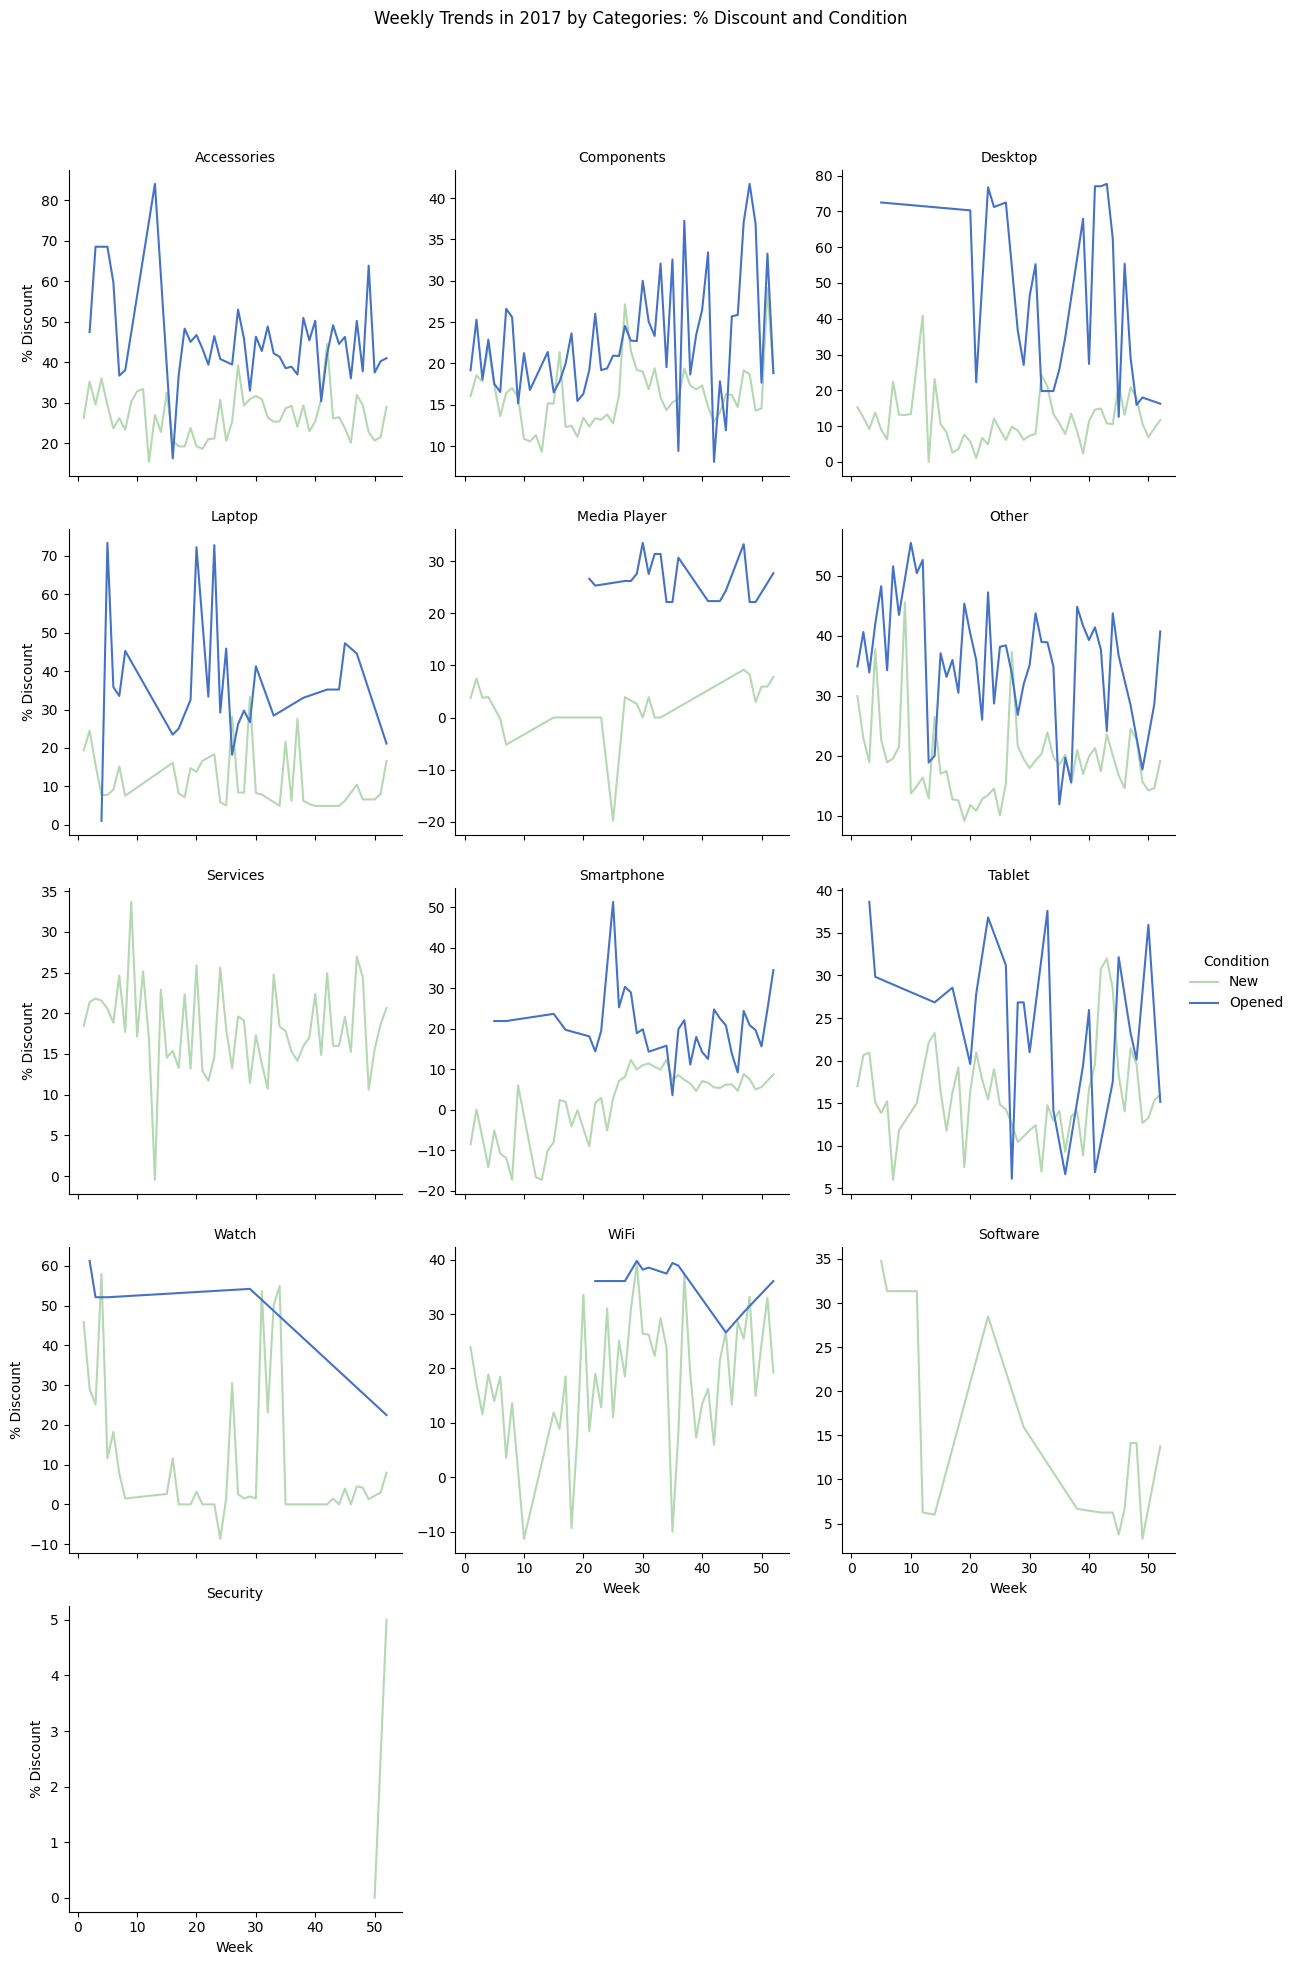

In [63]:
#opened items get the highest discount % which might pull the avg across new and opened

# Filterung data to include only rows where the year is 2017
filtered_data = all_tables[all_tables['year'] == 2017]

# Grouping data by 'week', 'categories', and 'condition' to calculate averages
grouped_data = (
    filtered_data.groupby(['week', 'category', 'condition'])
    .agg(
        avg_percentage_change=('%_change', 'mean'),
        avg_product_quantity=('product_quantity', 'sum')
    )
    .reset_index()
)

palette = {'New': 'green','Opened': 'blue'}

# Setting up a FacetGrid to create subplots for each category
g = sns.FacetGrid(
    grouped_data,
    col="category",
    col_wrap=3,  # Adjust to control the number of columns in the grid
    height=4,
    sharex=True,
    sharey=False
)

# Adding line plots for avg_percentage_change (primary y-axis)
g.map_dataframe(
    sns.lineplot,
    x="week",
    y="avg_percentage_change",
    hue="condition",
    #palette=palette,
    palette=color_palette
)
g.set_axis_labels("Week", "% Discount")
g.set_titles("{col_name}")
g.add_legend(title="Condition")

# Customizing the layout and show the plot
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Weekly Trends in 2017 by Categories: % Discount and Condition")
plt.show()
